<a href="https://colab.research.google.com/github/NHidden/resorvior/blob/master/rev07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Read data

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# PyDrive Authentication
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


link = 'https://drive.google.com/open?id=1Rx0s6C0HNrB-PZVtOwH3xzZ9juA9QSky' # trs_reservoir.csv
# link = 'https://drive.google.com/open?id=1RcGrsYDcd_9piqrq4cd1s_HxS2Wc8pUR' # trs_data_month

fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')

1Rx0s6C0HNrB-PZVtOwH3xzZ9juA9QSky


Note: using Google CoLab


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(517303, 12)
(346593, 6) 346593 (346593,)
(346593, 1, 6) (346593,) (170710, 1, 6) (170710,)
Epoch 1/10
2889/2889 - 12s - loss: 0.0764 - val_loss: 0.0371
Epoch 2/10
2889/2889 - 12s - loss: 0.0153 - val_loss: 0.0121
Epoch 3/10
2889/2889 - 12s - loss: 0.0044 - val_loss: 0.0096
Epoch 4/10
2889/2889 - 12s - loss: 0.0039 - val_loss: 0.0048
Epoch 5/10
2889/2889 - 12s - loss: 0.0038 - val_loss: 0.0048
Epoch 6/10
2889/2889 - 12s - loss: 0.0036 - val_loss: 0.0065
Epoch 7/10
2889/2889 - 12s - loss: 0.0034 - val_loss: 0.0039
Epoch 8/10
2889/2889 - 12s - loss: 0.0035 - val_loss: 0.0057
Epoch 9/10
2889/2889 - 12s - loss: 0.0033 - val_loss: 0.0033
Epoch 10/10
2889/2889 - 12s - loss: 0.0032 - val_loss: 0.0030


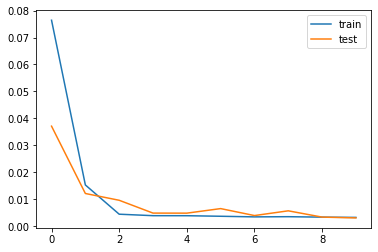

Test RMSE: 3.134


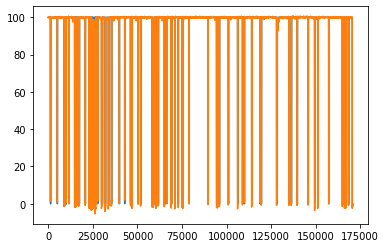

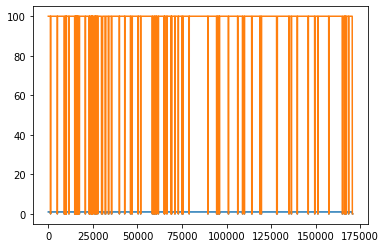

In [0]:
try:
    from google.colab import drive
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
DF = pd.read_csv('Filename.csv',na_values={"Err","null"}, header=0, index_col=0)
# features in csv = [weekdays H1(m) H2(m) pump(kW) T(kg/ cm^3) Q(m^3/h)...
#                    V1(%) Q1(m^3/h) S1_1(m) S1_2(m) T1(kg/ cm^3)...
# 									          V2(%) T2(kg/ cm^3) Q2(m^3/h) S2_1(m) S2_2(m) m^3/h...
# 														     V3_1(%) V3_2(%) Q3(m^3/h) T3(kg/ cm^3) S3_1(m)	S3_2(m)...
# 																   V4(%)	T4(kg/ cm^3)	Q4(m^3/h)	S4_1(m)	S4_2(m)	W4(m^3/h)	D1(m^3/h)	D2(m^3/h)]

EPOCH=10

# train S1 #####################################################################
#S1_1, S1_2를 하나로 바꿔야됨.
features_considered = ['V1(%)','V2(%)','V4(%)','Q(m^3/h)','Q1(m^3/h)','S1_1(m)','S1_2(m)']
dataset = DF[features_considered]
dataset.columns = ['V1','V2','V4','Q','Q1','S1_1','S1_2']
dataset['S1']=(dataset['S1_1']+dataset['S1_2'])/2
del dataset['S1_1']
del dataset['S1_2']
# display(dataset)
dataset = dataset.dropna(how='any')
# specify the number of lag hours
n_hours = 1
n_features = 6
# ensure all data is float
values = dataset.values
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

# split into train and test sets
values = reframed.values
# n_train_hours = 365 * 24
n_train_hours = int(len(dataset) * 0.67)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
S1 = tf.keras.models.Sequential()
S1.add(tf.keras.layers.LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
S1.add(tf.keras.layers.Dense(1))
S1.compile(loss='mae', optimizer='adam')
# fit network
history = S1.fit(train_X, train_y, epochs=EPOCH, batch_size=120, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = S1.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -n_features+1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -n_features+1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
t = np.arange(0, len(inv_y))
plt.plot(t,inv_y, t,inv_yhat)
plt.show()

plt.plot(t,test_y, t,inv_y)
plt.show()

**train** models

Note: using Google CoLab


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:393: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(517303, 12)
(346593, 6) 346593 (346593,)
(346593, 1, 6) (346593,) (170710, 1, 6) (170710,)
Epoch 1/10
2889/2889 - 10s - loss: 0.0884 - val_loss: 0.0520
Epoch 2/10
2889/2889 - 9s - loss: 0.0304 - val_loss: 0.0318
Epoch 3/10
2889/2889 - 9s - loss: 0.0110 - val_loss: 0.0080
Epoch 4/10
2889/2889 - 9s - loss: 0.0039 - val_loss: 0.0053
Epoch 5/10
2889/2889 - 9s - loss: 0.0027 - val_loss: 0.0044
Epoch 6/10
2889/2889 - 9s - loss: 0.0028 - val_loss: 0.0042
Epoch 7/10
2889/2889 - 9s - loss: 0.0026 - val_loss: 0.0033
Epoch 8/10
2889/2889 - 9s - loss: 0.0026 - val_loss: 0.0033
Epoch 9/10
2889/2889 - 9s - loss: 0.0025 - val_loss: 0.0028
Epoch 10/10
2889/2889 - 9s - loss: 0.0024 - val_loss: 0.0032


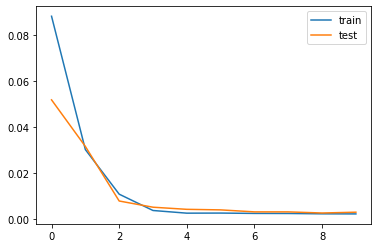

Test RMSE: 3.138


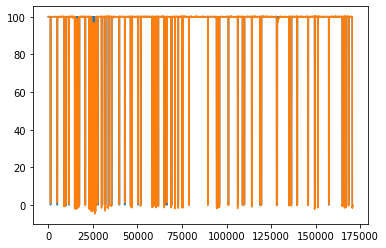

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(517305, 12)
(346595, 6) 346595 (346595,)
(346595, 1, 6) (346595,) (170710, 1, 6) (170710,)
Epoch 1/10
2889/2889 - 9s - loss: 0.0967 - val_loss: 0.0554
Epoch 2/10
2889/2889 - 9s - loss: 0.0253 - val_loss: 0.0196
Epoch 3/10
2889/2889 - 9s - loss: 0.0085 - val_loss: 0.0062
Epoch 4/10
2889/2889 - 9s - loss: 0.0043 - val_loss: 0.0037
Epoch 5/10
2889/2889 - 9s - loss: 0.0037 - val_loss: 0.0039
Epoch 6/10
2889/2889 - 9s - loss: 0.0032 - val_loss: 0.0035
Epoch 7/10
2889/2889 - 9s - loss: 0.0031 - val_loss: 0.0047
Epoch 8/10
2889/2889 - 10s - loss: 0.0029 - val_loss: 0.0045
Epoch 9/10
2889/2889 - 9s - loss: 0.0026 - val_loss: 0.0034
Epoch 10/10
2889/2889 - 9s - loss: 0.0027 - val_loss: 0.0041


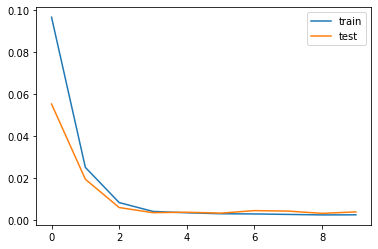

Test RMSE: 3.115


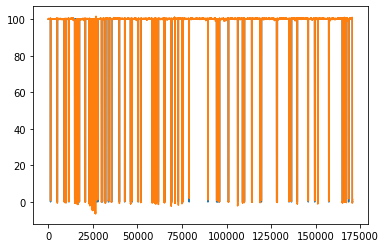

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:533: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(517304, 12)
(346594, 6) 346594 (346594,)
(346594, 1, 6) (346594,) (170710, 1, 6) (170710,)
Epoch 1/10
2889/2889 - 9s - loss: 0.0632 - val_loss: 0.0245
Epoch 2/10
2889/2889 - 9s - loss: 0.0059 - val_loss: 0.0101
Epoch 3/10
2889/2889 - 9s - loss: 0.0041 - val_loss: 0.0059
Epoch 4/10
2889/2889 - 9s - loss: 0.0038 - val_loss: 0.0094
Epoch 5/10
2889/2889 - 9s - loss: 0.0034 - val_loss: 0.0058
Epoch 6/10
2889/2889 - 9s - loss: 0.0033 - val_loss: 0.0047
Epoch 7/10
2889/2889 - 9s - loss: 0.0031 - val_loss: 0.0046
Epoch 8/10
2889/2889 - 9s - loss: 0.0030 - val_loss: 0.0046
Epoch 9/10
2889/2889 - 9s - loss: 0.0027 - val_loss: 0.0045
Epoch 10/10
2889/2889 - 9s - loss: 0.0027 - val_loss: 0.0054


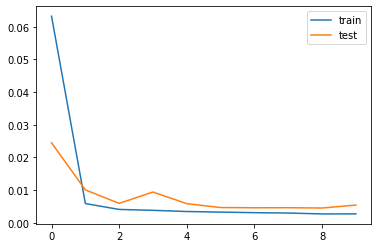

Test RMSE: 3.164


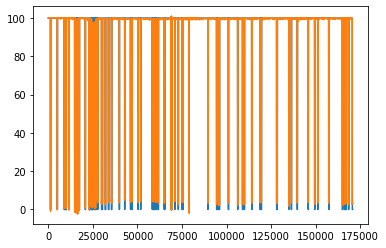

In [0]:
try:
    from google.colab import drive
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
DF = pd.read_csv('Filename.csv',na_values={"Err","null"}, header=0, index_col=0)
# features in csv = [weekdays H1(m) H2(m) pump(kW) T(kg/ cm^3) Q(m^3/h)...
#                    V1(%) Q1(m^3/h) S1_1(m) S1_2(m) T1(kg/ cm^3)...
# 									          V2(%) T2(kg/ cm^3) Q2(m^3/h) S2_1(m) S2_2(m) m^3/h...
# 														     V3_1(%) V3_2(%) Q3(m^3/h) T3(kg/ cm^3) S3_1(m)	S3_2(m)...
# 																   V4(%)	T4(kg/ cm^3)	Q4(m^3/h)	S4_1(m)	S4_2(m)	W4(m^3/h)	D1(m^3/h)	D2(m^3/h)]

EPOCH=10

# # train D #####################################################################
# features_considered = ['weekdays','D1(m^3/h)','D2(m^3/h)']
# dataset = DF[features_considered]
# dataset.columns = ['weekdays','D1','D2']
# dataset['D']=dataset['D1']+dataset['D2']
# del dataset['D1']
# del dataset['D2']
# dataset = dataset.dropna(how='any')
# # specify the number of lag hours
# n_hours = 1
# n_features = 2
# # ensure all data is float
# values = dataset.values
# values = values.astype('float32')
# # normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)
# # frame as supervised learning
# reframed = series_to_supervised(scaled, n_hours, 1)
# print(reframed.shape)

# # split into train and test sets
# values = reframed.values
# # n_train_hours = 365 * 24
# n_train_hours = int(len(dataset) * 0.67)
# train = values[:n_train_hours, :]
# test = values[n_train_hours:, :]
# # split into input and outputs
# n_obs = n_hours * n_features
# train_X, train_y = train[:, :n_obs], train[:, -n_features]
# test_X, test_y = test[:, :n_obs], test[:, -n_features]
# print(train_X.shape, len(train_X), train_y.shape)
# # reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
# test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# # design network
# D = tf.keras.models.Sequential()
# D.add(tf.keras.layers.LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
# D.add(tf.keras.layers.Dense(1))
# D.compile(loss='mae', optimizer='adam')
# # fit network
# history = D.fit(train_X, train_y, epochs=EPOCH, batch_size=120, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# # plot history
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend()
# pyplot.show()

# # make a prediction
# yhat = D.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# # invert scaling for forecast
# inv_yhat = concatenate((yhat, test_X[:, -n_features+1:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]
# # invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = concatenate((test_y, test_X[:, -n_features+1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]
# # calculate RMSE
# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)
# t = np.arange(0, len(inv_y))
# plt.plot(t,inv_y, t,inv_yhat)
# plt.show()

# train Q ######################################################################
# features_considered = ['T(kg/ cm^3)','V1(%)','V2(%)','V4(%)','Q(m^3/h)']
# dataset = DF[features_considered]
# # dataset.columns = ['pump','T','V1','Q1','V2','Q2','V4','Q4','Q']
# dataset.columns = ['T','V1','V2','V4','Q']
# dataset = dataset.dropna(how='any')
# # specify the number of lag hours
# n_hours = 1
# n_features = 5
# # ensure all data is float
# values = dataset.values
# values = values.astype('float32')
# # normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)
# # frame as supervised learning
# reframed = series_to_supervised(scaled, n_hours, 1)
# print(reframed.shape)

# # split into train and test sets
# values = reframed.values
# # n_train_hours = 365 * 24
# n_train_hours = int(len(dataset) * 0.67)
# train = values[:n_train_hours, :]
# test = values[n_train_hours:, :]
# # split into input and outputs
# n_obs = n_hours * n_features
# train_X, train_y = train[:, :n_obs], train[:, -n_features]
# test_X, test_y = test[:, :n_obs], test[:, -n_features]
# print(train_X.shape, len(train_X), train_y.shape)
# # reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
# test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# # design network
# Q = tf.keras.models.Sequential()
# Q.add(tf.keras.layers.LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
# Q.add(tf.keras.layers.Dense(1))
# Q.compile(loss='mae', optimizer='adam')
# # fit network
# history = Q.fit(train_X, train_y, epochs=EPOCH, batch_size=120, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# # plot history
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend()
# pyplot.show()

# # make a prediction
# yhat = Q.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# # invert scaling for forecast
# inv_yhat = concatenate((yhat, test_X[:, -n_features+1:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]
# # invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = concatenate((test_y, test_X[:, -n_features+1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]
# # calculate RMSE
# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)
# t = np.arange(0, len(inv_y))
# plt.plot(t,inv_y, t,inv_yhat)
# plt.show()

# train Q1 #####################################################################
# features_considered = ['V1(%)','V2(%)','V4(%)','Q(m^3/h)','Q1(m^3/h)']
# dataset = DF[features_considered]
# dataset.columns = ['V1','V2','V4','Q','Q1']
# dataset = dataset.dropna(how='any')
# # specify the number of lag hours
# n_hours = 1
# n_features = 5
# # ensure all data is float
# values = dataset.values
# values = values.astype('float32')
# # normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)
# # frame as supervised learning
# reframed = series_to_supervised(scaled, n_hours, 1)
# print(reframed.shape)

# # split into train and test sets
# values = reframed.values
# # n_train_hours = 365 * 24
# n_train_hours = int(len(dataset) * 0.67)
# train = values[:n_train_hours, :]
# test = values[n_train_hours:, :]
# # split into input and outputs
# n_obs = n_hours * n_features
# train_X, train_y = train[:, :n_obs], train[:, -n_features]
# test_X, test_y = test[:, :n_obs], test[:, -n_features]
# print(train_X.shape, len(train_X), train_y.shape)
# # reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
# test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# # design network
# Q1 = tf.keras.models.Sequential()
# Q1.add(tf.keras.layers.LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
# Q1.add(tf.keras.layers.Dense(1))
# Q1.compile(loss='mae', optimizer='adam')
# # fit network
# history = Q1.fit(train_X, train_y, epochs=EPOCH, batch_size=120, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# # plot history
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend()
# pyplot.show()

# # make a prediction
# yhat = Q.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# # invert scaling for forecast
# inv_yhat = concatenate((yhat, test_X[:, -n_features+1:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]
# # invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = concatenate((test_y, test_X[:, -n_features+1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]
# # calculate RMSE
# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)
# t = np.arange(0, len(inv_y))
# plt.plot(t,inv_y, t,inv_yhat)
# plt.show()

# # train Q2 #####################################################################
# features_considered = ['V1(%)','V2(%)','V4(%)','Q(m^3/h)','Q2(m^3/h)']
# dataset = DF[features_considered]
# dataset.columns = ['V1','V2','V4','Q','Q2']
# dataset = dataset.dropna(how='any')
# # specify the number of lag hours
# n_hours = 1
# n_features = 5
# # ensure all data is float
# values = dataset.values
# values = values.astype('float32')
# # normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)
# # frame as supervised learning
# reframed = series_to_supervised(scaled, n_hours, 1)
# print(reframed.shape)

# # split into train and test sets
# values = reframed.values
# # n_train_hours = 365 * 24
# n_train_hours = int(len(dataset) * 0.67)
# train = values[:n_train_hours, :]
# test = values[n_train_hours:, :]
# # split into input and outputs
# n_obs = n_hours * n_features
# train_X, train_y = train[:, :n_obs], train[:, -n_features]
# test_X, test_y = test[:, :n_obs], test[:, -n_features]
# print(train_X.shape, len(train_X), train_y.shape)
# # reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
# test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# # design network
# Q2 = tf.keras.models.Sequential()
# Q2.add(tf.keras.layers.LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
# Q2.add(tf.keras.layers.Dense(1))
# Q2.compile(loss='mae', optimizer='adam')
# # fit network
# history = Q2.fit(train_X, train_y, epochs=EPOCH, batch_size=120, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# # plot history
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend()
# pyplot.show()

# # make a prediction
# yhat = Q.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# # invert scaling for forecast
# inv_yhat = concatenate((yhat, test_X[:, -n_features+1:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]
# # invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = concatenate((test_y, test_X[:, -n_features+1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]
# # calculate RMSE
# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)
# t = np.arange(0, len(inv_y))
# plt.plot(t,inv_y, t,inv_yhat)
# plt.show()

# # train Q4 #####################################################################
# features_considered = ['V1(%)','V2(%)','V4(%)','Q(m^3/h)','Q4(m^3/h)']
# dataset = DF[features_considered]
# dataset.columns = ['V1','V2','V4','Q','Q4']
# dataset = dataset.dropna(how='any')
# # specify the number of lag hours
# n_hours = 1
# n_features = 5
# # ensure all data is float
# values = dataset.values
# values = values.astype('float32')
# # normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)
# # frame as supervised learning
# reframed = series_to_supervised(scaled, n_hours, 1)
# print(reframed.shape)

# # split into train and test sets
# values = reframed.values
# # n_train_hours = 365 * 24
# n_train_hours = int(len(dataset) * 0.67)
# train = values[:n_train_hours, :]
# test = values[n_train_hours:, :]
# # split into input and outputs
# n_obs = n_hours * n_features
# train_X, train_y = train[:, :n_obs], train[:, -n_features]
# test_X, test_y = test[:, :n_obs], test[:, -n_features]
# print(train_X.shape, len(train_X), train_y.shape)
# # reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
# test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# # design network
# Q4 = tf.keras.models.Sequential()
# Q4.add(tf.keras.layers.LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
# Q4.add(tf.keras.layers.Dense(1))
# Q4.compile(loss='mae', optimizer='adam')
# # fit network
# history = Q4.fit(train_X, train_y, epochs=EPOCH, batch_size=120, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# # plot history
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend()
# pyplot.show()

# # make a prediction
# yhat = Q.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# # invert scaling for forecast
# inv_yhat = concatenate((yhat, test_X[:, -n_features+1:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]
# # invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = concatenate((test_y, test_X[:, -n_features+1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]
# # calculate RMSE
# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)
# t = np.arange(0, len(inv_y))
# plt.plot(t,inv_y, t,inv_yhat)
# plt.show()

# train S1 #####################################################################
features_considered = ['V1(%)','V2(%)','V4(%)','Q(m^3/h)','Q1(m^3/h)','S1_1(m)','S1_2(m)']
dataset = DF[features_considered]
dataset.columns = ['V1','V2','V4','Q','Q1','S1_1','S1_2']
dataset['S1']=(dataset['S1_1']+dataset['S1_2'])/2
del dataset['S1_1']
del dataset['S1_2']
# display(dataset)
dataset = dataset.dropna(how='any')
# specify the number of lag hours
n_hours = 1
n_features = 6
# ensure all data is float
values = dataset.values
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

# split into train and test sets
values = reframed.values
# n_train_hours = 365 * 24
n_train_hours = int(len(dataset) * 0.67)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
S1 = tf.keras.models.Sequential()
S1.add(tf.keras.layers.LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
S1.add(tf.keras.layers.Dense(1))
S1.compile(loss='mae', optimizer='adam')
# fit network
history = S1.fit(train_X, train_y, epochs=EPOCH, batch_size=120, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = S1.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -n_features+1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -n_features+1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
t = np.arange(0, len(inv_y))
plt.plot(t,inv_y, t,inv_yhat)
plt.show()

# train S2 #####################################################################
features_considered = ['V1(%)','V2(%)','V4(%)','Q(m^3/h)','Q2(m^3/h)','S2_1(m)','S2_2(m)']
dataset = DF[features_considered]
dataset.columns = ['V1','V2','V4','Q','Q2','S2_1','S2_2']
dataset['S2']=(dataset['S2_1']+dataset['S2_2'])/2
del dataset['S2_1']
del dataset['S2_2']
# display(dataset)
dataset = dataset.dropna(how='any')
# specify the number of lag hours
n_hours = 1
n_features = 6
# ensure all data is float
values = dataset.values
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

# split into train and test sets
values = reframed.values
# n_train_hours = 365 * 24
n_train_hours = int(len(dataset) * 0.67)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
S2 = tf.keras.models.Sequential()
S2.add(tf.keras.layers.LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
S2.add(tf.keras.layers.Dense(1))
S2.compile(loss='mae', optimizer='adam')
# fit network
history = S2.fit(train_X, train_y, epochs=EPOCH, batch_size=120, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = S2.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -n_features+1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -n_features+1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
t = np.arange(0, len(inv_y))
plt.plot(t,inv_y, t,inv_yhat)
plt.show()

# train S4 #####################################################################
features_considered = ['V1(%)','V2(%)','V4(%)','Q(m^3/h)','Q4(m^3/h)','S4_1(m)','S4_2(m)']
dataset = DF[features_considered]
dataset.columns = ['V1','V2','V4','Q','Q4','S4_1','S4_2']
dataset['S4']=(dataset['S4_1']+dataset['S4_2'])/2
del dataset['S4_1']
del dataset['S4_2']
# display(dataset)
dataset = dataset.dropna(how='any')
# specify the number of lag hours
n_hours = 1
n_features = 6
# ensure all data is float
values = dataset.values
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

# split into train and test sets
values = reframed.values
# n_train_hours = 365 * 24
n_train_hours = int(len(dataset) * 0.67)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
S4 = tf.keras.models.Sequential()
S4.add(tf.keras.layers.LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
S4.add(tf.keras.layers.Dense(1))
S4.compile(loss='mae', optimizer='adam')
# fit network
history = S4.fit(train_X, train_y, epochs=EPOCH, batch_size=120, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = S4.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -n_features+1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -n_features+1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
t = np.arange(0, len(inv_y))
plt.plot(t,inv_y, t,inv_yhat)
plt.show()

In [0]:
display(test_y.shape)
# test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# display(test_X)

(323368, 1)

# Result display

In [0]:
import matplotlib.pyplot as plt
import numpy as np
t = np.arange(0, len(inv_y))
plt.plot(t,inv_y, t,inv_yhat)
plt.show()

plt.plot(t,inv_y)
#inv_yhat(예측값), inv_y(실제값)
plt.show()

plt.plot(t,inv_yhat)
plt.show()

#PSO(V1,V2,V4) => min(cost)

In [0]:
pip install --upgrade pyswarm

ERROR! Session/line number was not unique in database. History logging moved to new session 60
  Created wheel for pyswarm: filename=pyswarm-0.6-cp36-none-any.whl size=4481 sha256=e68ebde796e4ac12fa7d5c2037364d3ae755125c543031646c5f0f010895c65b
  Stored in directory: /root/.cache/pip/wheels/37/c5/f6/b33b9ac00040cb95c1f00af982a4197334a672d6de43f4699f
Successfully built pyswarm


In [0]:
import numpy as np
from pyswarm import pso

# Define the objective (to be minimize)
def weight(x, *args):
    H, d, t = x
    B, rho, E, P = args
    return rho*2*np.pi*d*t*np.sqrt((B/2)**2 + H**2)

# Setup the constraint functions
def yield_stress(x, *args):
    H, d, t = x
    B, rho, E, P = args
    return (P*np.sqrt((B/2)**2 + H**2))/(2*t*np.pi*d*H)

def buckling_stress(x, *args):
    H, d, t = x
    B, rho, E, P = args
    return (np.pi**2*E*(d**2 + t**2))/(8*((B/2)**2 + H**2))

def deflection(x, *args):
    H, d, t = x
    B, rho, E, P = args
    return (P*np.sqrt((B/2)**2 + H**2)**3)/(2*t*np.pi*d*H**2*E)

def constraints(x, *args):
    strs = yield_stress(x, *args)
    buck = buckling_stress(x, *args)
    defl = deflection(x, *args)
    return [100 - strs, buck - strs, 0.25 - defl]

# Define the other parameters
B = 60  # inches
rho = 0.3  # lb/in^3
E = 30000  # kpsi (1000-psi)
P = 66  # kip (1000-lbs, force)
args = (B, rho, E, P)

# Define the lower and upper bounds for H, d, t, respectively
lb = [10, 1, 0.01]
ub = [30, 3, 0.25]

xopt, fopt = pso(weight, lb, ub, f_ieqcons=constraints, args=args)

# The optimal input values are approximately
#     xopt = [29, 2.4, 0.06]
# with function values approximately
#     weight          = 12 lbs
#     yield stress    = 100 kpsi (binding constraint)
#     buckling stress = 150 kpsi
#     deflection      = 0.2 in
xopt

Stopping search: maximum iterations reached --> 100


array([27.22305234,  2.77008211,  0.05642888])